In [1]:
# READ DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from google.colab import files
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import tensorflow as tf
import random

# Import Data

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Revisi%20Analisis/Data%20TMA%20(Jan%202022%20-%20Juni%202025).csv')
data = data.loc[:, ['Daily_Period', 'TMA_Daily']]
data = data.iloc[:1215].reset_index(drop=True)

print(data.head())
print(data.tail())

  Daily_Period  TMA_Daily
0   01/01/2022       10.0
1   02/01/2022       10.0
2   03/01/2022       10.0
3   04/01/2022       10.0
4   05/01/2022       12.5
     Daily_Period  TMA_Daily
1210   25/04/2025  20.000000
1211   26/04/2025  20.000000
1212   27/04/2025  20.000000
1213   28/04/2025  21.666667
1214   29/04/2025  20.000000


In [4]:
print(data.describe())

         TMA_Daily
count  1215.000000
mean     18.163724
std       9.973607
min      10.000000
25%      10.000000
50%      14.166667
75%      22.916667
max      80.833333


# Eksplorasi Data

Jumlah data latih: 1095
Jumlah data validasi: 60
Jumlah data uji: 60


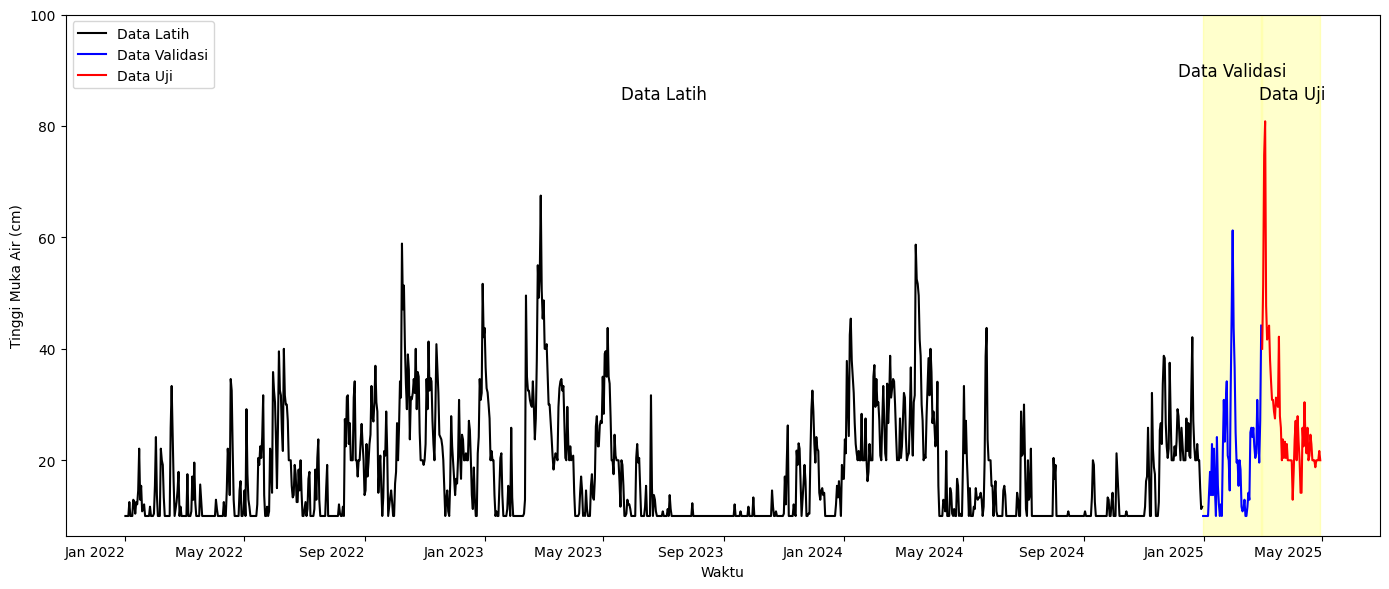

Dimensi data latih: (1095, 2)
Dimensi data validasi: (60, 2)
Dimensi data uji: (60, 2)


In [5]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
import pandas as pd
import matplotlib.dates as mdates

# Pastikan kolom waktu dalam format datetime
data['Daily_Period'] = pd.to_datetime(data['Daily_Period'], format='%d/%m/%Y')

# Pembagian data
train_data = data.iloc[:1095]
val_data = data.iloc[1095:1155]
test_data = data.iloc[1155:1215]

# Cek jumlah
print("Jumlah data latih:", len(train_data))
print("Jumlah data validasi:", len(val_data))
print("Jumlah data uji:", len(test_data))

# Plot
plt.figure(figsize=(14, 6))

# Garis data
plt.plot(train_data['Daily_Period'], train_data['TMA_Daily'], label='Data Latih', color='black')
plt.plot(val_data['Daily_Period'], val_data['TMA_Daily'], label='Data Validasi', color='blue')
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'], label='Data Uji', color='red')

# Highlight area validasi (kuning)
plt.axvspan(val_data['Daily_Period'].iloc[0], val_data['Daily_Period'].iloc[-1], color='yellow', alpha=0.2)

# Highlight area uji (pink)
plt.axvspan(test_data['Daily_Period'].iloc[0], test_data['Daily_Period'].iloc[-1], color='yellow', alpha=0.2)

# Label sumbu
plt.xlabel('Waktu')
plt.ylabel('Tinggi Muka Air (cm)')
plt.ylim(top=100)
# plt.title('Plot Data Latih, Validasi, dan Uji')

# Format tanggal: Jan, Mei, Sep
plt.gca().xaxis.set_major_locator(MonthLocator(bymonth=[1, 5, 9]))
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate(rotation=0)

# Label teks di atas area
plt.text(train_data['Daily_Period'].iloc[len(train_data)//2],
         data['TMA_Daily'].max() * 1.05, 'Data Latih', ha='center', fontsize=12)
plt.text(val_data['Daily_Period'].iloc[len(val_data)//2],
         data['TMA_Daily'].max() * 1.1, 'Data Validasi', ha='center', fontsize=12)
plt.text(test_data['Daily_Period'].iloc[len(test_data)//2],
         data['TMA_Daily'].max() * 1.05, 'Data Uji', ha='center', fontsize=12)

# Legend & show
plt.legend()
plt.tight_layout()
plt.show()

# Dimensi
print('Dimensi data latih:', train_data.shape)
print('Dimensi data validasi:', val_data.shape)
print('Dimensi data uji:', test_data.shape)

# Hyperparameter Tuning LSTM

In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.initializers import GlorotUniform

In [7]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Menentukan ukuran data
train_size = 1095
val_size = 60
test_size = 60

# Membagi data menjadi train, val, test
train_data = time_series_data[:train_size]
val_data = time_series_data[train_size:train_size + val_size]
test_data = time_series_data[train_size + val_size:train_size + val_size + test_size]

# Fungsi untuk membuat sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Time step
seq_length = 30

# Membuat sekuens untuk masing-masing data
X_train = create_sequences(train_data, seq_length)
X_val = create_sequences(val_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]

y_val = X_val[:, -1]
X_val = X_val[:, :-1]

y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshape untuk LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Fungsi untuk membuat model LSTM
def create_model():
    optimizer = Adam(learning_rate=0.005)
    model = Sequential()
    model.add(LSTM(
        50,
        activation='tanh',
        input_shape=(seq_length - 1, 1),
        kernel_initializer=HeUniform(),
        recurrent_initializer=HeUniform(),
        bias_initializer='zeros'
    ))
    model.add(Dropout(0.01))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Fungsi untuk menghitung AIC
def calculate_aic(n, mse, num_params):
    return n * np.log(mse) + 2 * num_params

# Inisialisasi model
model = create_model()

# Simpan nilai AIC per epoch
aic_values = []

# Epoch yang diuji
epochs_to_test = [10, 50, 100, 150, 200, 250]

# Evaluasi model di data validasi
for epoch in epochs_to_test:
    model.fit(X_train, y_train, epochs=epoch, batch_size=16, verbose=0)

    # Prediksi pada data validasi
    y_pred_val = model.predict(X_val)

    # Hitung MSE
    mse = mean_squared_error(y_val, y_pred_val)

    # Hitung AIC
    n = len(y_val)
    num_params = len(model.trainable_weights)
    aic = calculate_aic(n, mse, num_params)

    aic_values.append(aic)
    print(f"Epoch {epoch} - AIC: {aic:.4f}")

# Tampilkan semua nilai AIC
print("AIC values per epoch:", aic_values)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Epoch 10 - AIC: -128.7757
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 50 - AIC: -113.3410
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 100 - AIC: -96.9759
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 150 - AIC: -100.9156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 200 - AIC: -106.4666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 250 - AIC: -106.1005
AIC values per epoch: [np.float64(-128.77565099741213), np.float64(-113.34103259196746), np.float64(-96.97587733311582), np.float64(-100.91555055974631), np.float64(-106.46658902196644), np.float64(-106.10053536955175)]


In [8]:
print(X_train)

[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.00588235]]

 [[0.        ]
  [0.        ]
  [0.03529412]
  ...
  [0.        ]
  [0.00588235]
  [0.07647059]]

 ...

 [[0.25294118]
  [0.14117647]
  [0.14117647]
  ...
  [0.14117647]
  [0.18235294]
  [0.14117647]]

 [[0.14117647]
  [0.14117647]
  [0.14117647]
  ...
  [0.18235294]
  [0.14117647]
  [0.14117647]]

 [[0.14117647]
  [0.14117647]
  [0.17647059]
  ...
  [0.14117647]
  [0.14117647]
  [0.07058824]]]


In [9]:
print(X_val)

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.05882353]
  [0.11176471]
  [0.05294118]
  [0.18235294]
  [0.05294118]
  [0.17058824]
  [0.06470588]
  [0.        ]
  [0.2       ]
  [0.07647059]
  [0.02941176]
  [0.        ]
  [0.02941176]
  [0.        ]
  [0.16470588]
  [0.29411765]
  [0.18823529]
  [0.28823529]
  [0.34117647]
  [0.15294118]
  [0.14117647]
  [0.06470588]
  [0.31764706]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.05882353]
  [0.11176471]
  [0.05294118]
  [0.18235294]
  [0.05294118]
  [0.17058824]
  [0.06470588]
  [0.        ]
  [0.2       ]
  [0.07647059]
  [0.02941176]
  [0.        ]
  [0.02941176]
  [0.        ]
  [0.16470588]
  [0.29411765]
  [0.18823529]
  [0.28823529]
  [0.34117647]
  [0.15294118]
  [0.14117647]
  [0.06470588]
  [0.31764706]
  [0.51764706]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.05882353]
  [0.11176471]
  [0.05294118]
  [0.18235294]
  [0.0

# LSTM Final

In [10]:
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Membangun model LSTM dengan aktivasi tanh dan init_scheme glorot_uniform
optimizer = Adam(learning_rate=0.005)  # Learning Rate Best Params
model = Sequential()
model.add(LSTM(
    50,
    activation='tanh',  # Fungsi aktivasi
    input_shape=(seq_length - 1, 1),
    kernel_initializer=HeUniform(),        # Init Scheme Input
    recurrent_initializer=HeUniform(),     # Init Scheme Recurrent (hidden)
    bias_initializer='zeros'
))
model.add(Dropout(0.01))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')

# Melatih model dengan data validasi (bukan test)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=10
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

# Prediksi dengan Model LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


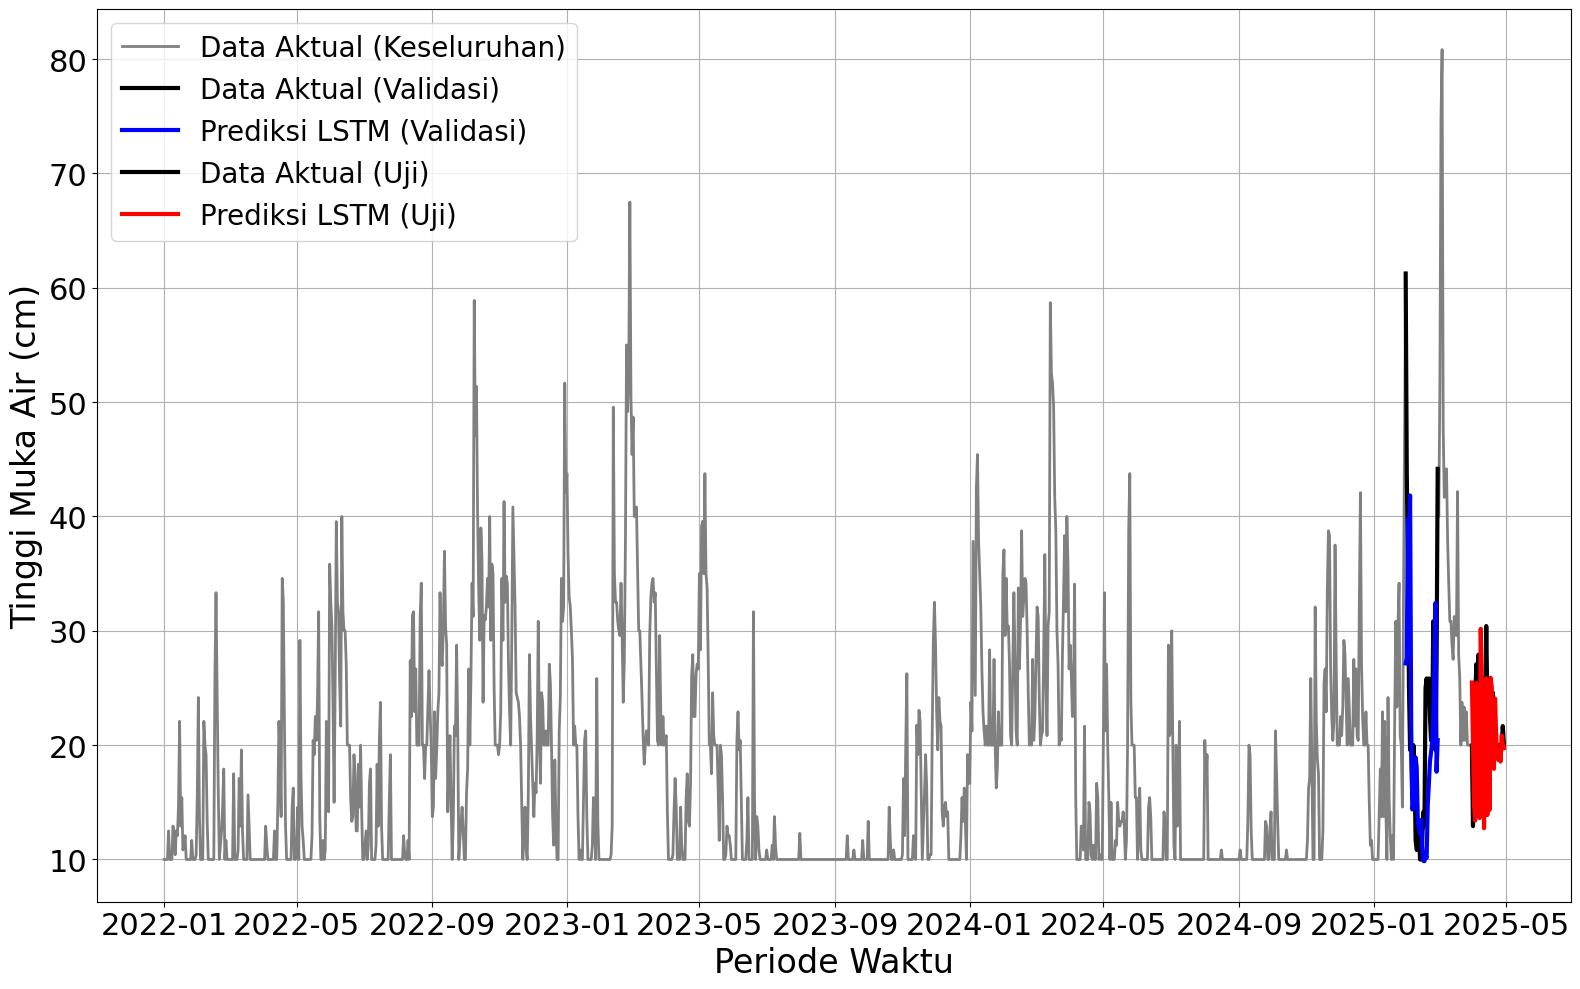

In [11]:
# --- Prediksi Validasi ---
pred_val = model.predict(X_val)
inv_val = scaler.inverse_transform(
    np.concatenate((X_val[:, -1], pred_val.reshape(-1, 1)), axis=1)
)[:, 1]

# --- Prediksi Uji ---
pred_test = model.predict(X_test)
inv_test = scaler.inverse_transform(
    np.concatenate((X_test[:, -1], pred_test.reshape(-1, 1)), axis=1)
)[:, 1]

# --- Indeks waktu ---
val_start_idx = train_size + seq_length
val_end_idx = val_start_idx + len(inv_val)

test_start_idx = train_size + val_size + seq_length
test_end_idx = test_start_idx + len(inv_test)

# --- Plot gabungan ---
plt.figure(figsize=(16, 10))

# Data aktual keseluruhan
plt.plot(data['Daily_Period'], data['TMA_Daily'].values,
         lw=2, label='Data Aktual (Keseluruhan)', color='gray')

# Data aktual validasi
plt.plot(data['Daily_Period'][val_start_idx:val_end_idx],
         data['TMA_Daily'].values[val_start_idx:val_end_idx],
         lw=3, label='Data Aktual (Validasi)', color='black')

# Prediksi LSTM validasi
plt.plot(data['Daily_Period'][val_start_idx:val_end_idx],
         inv_val, lw=3, label='Prediksi LSTM (Validasi)', color='blue')

# Data aktual uji
plt.plot(data['Daily_Period'][test_start_idx:test_end_idx],
         data['TMA_Daily'].values[test_start_idx:test_end_idx],
         lw=3, label='Data Aktual (Uji)', color='black')

# Prediksi LSTM uji
plt.plot(data['Daily_Period'][test_start_idx:test_end_idx],
         inv_test, lw=3, label='Prediksi LSTM (Uji)', color='red')

# Format
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

# Nilai MAPE (Testing)

In [12]:
from sklearn.metrics import mean_absolute_percentage_error

# Indeks awal dan akhir validasi
val_start_idx = train_size + seq_length
val_end_idx = val_start_idx + len(inv_val)

# Indeks awal dan akhir uji
test_start_idx = train_size + val_size + seq_length
test_end_idx = test_start_idx + len(inv_test)

# MAPE Validasi (%)
mape_val = mean_absolute_percentage_error(
    data['TMA_Daily'].values[val_start_idx:val_end_idx],
    inv_val
) * 100

# MAPE Uji (%)
mape_test = mean_absolute_percentage_error(
    data['TMA_Daily'].values[test_start_idx:test_end_idx],
    inv_test
) * 100

# Tampilkan hasil dengan 2 desimal
print(f'MAPE Validasi: {mape_val:.2f}%')
print(f'MAPE Uji     : {mape_test:.2f}%')

MAPE Validasi: 33.17%
MAPE Uji     : 24.88%


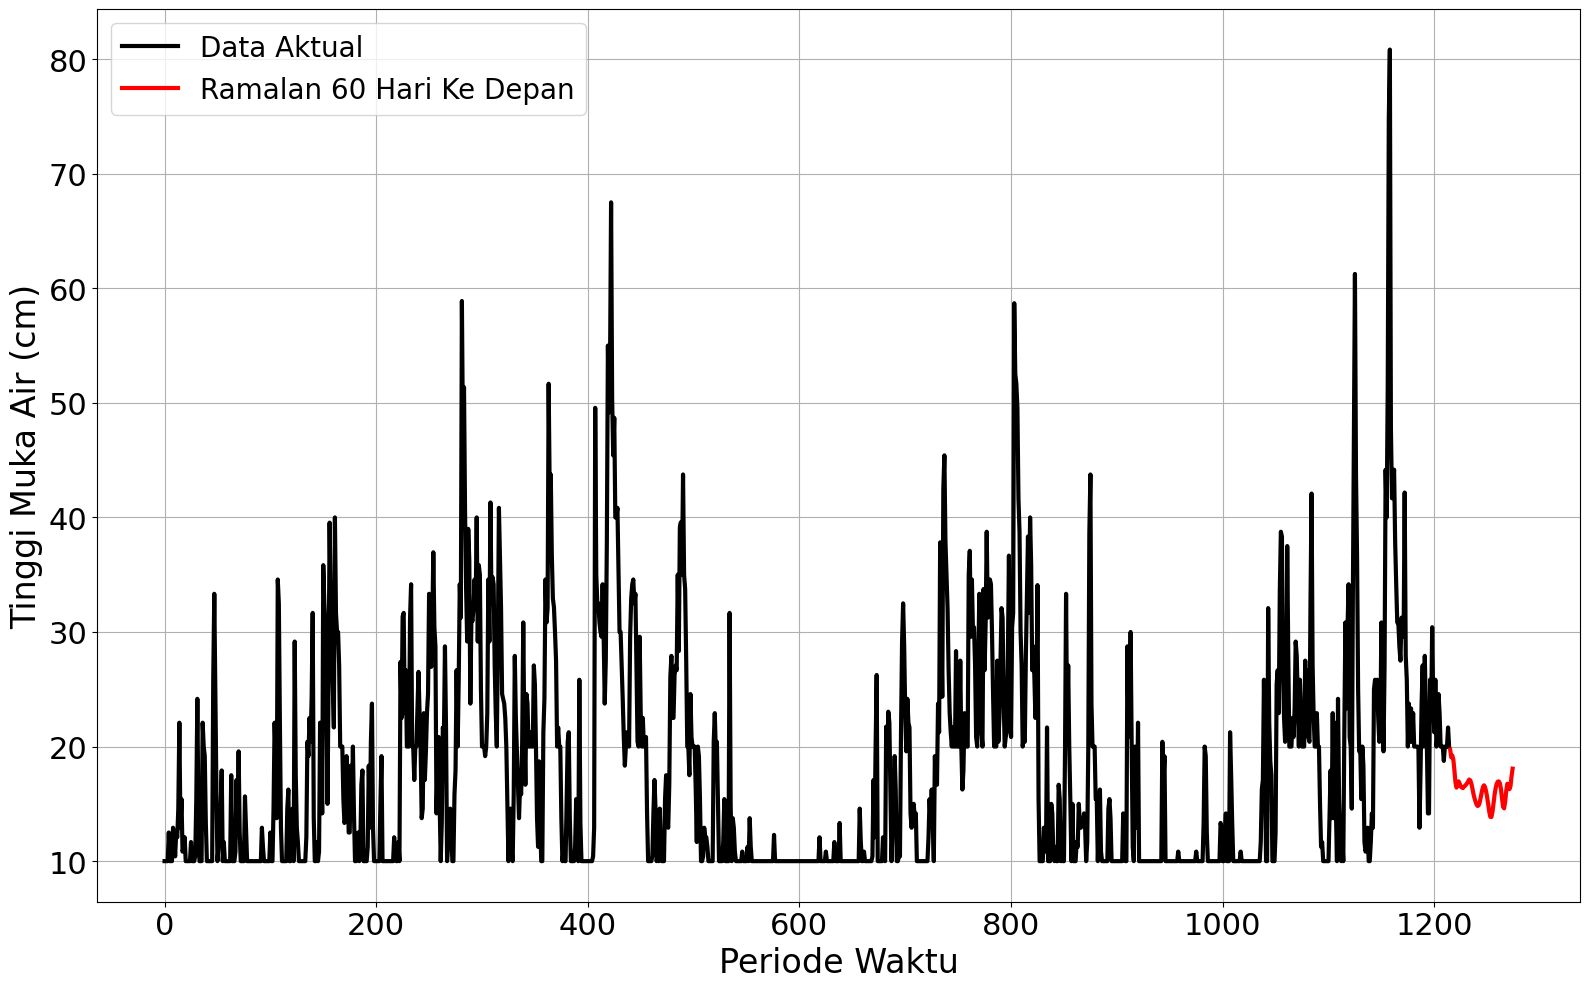

In [13]:
# Menyiapkan data untuk membuat prediksi ke depan
future_steps = 60
future_data = X_test[-1]  # Menggunakan data terakhir dari data uji sebagai input awal

# Membuat prediksi ke depan
future_predictions = []
for i in range(future_steps):
    prediction = model.predict(future_data.reshape(1, seq_length - 1, 1), verbose=0)
    future_predictions.append(prediction[0, 0])
    future_data = np.append(future_data[1:], prediction[0])  # Perbarui input window

# Invers transform hasil prediksi ke skala aslinya
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Visualisasi hasil prediksi ke depan bersama dengan data asli
plt.figure(figsize=(16, 10))

# Plot seluruh data aktual
plt.plot(np.arange(len(time_series_data)),
         scaler.inverse_transform(time_series_data),
         lw=3, label='Data Aktual', color='black')

# Plot hasil prediksi 60 periode ke depan
plt.plot(np.arange(len(time_series_data), len(time_series_data) + future_steps),
         future_predictions,
         lw=3, label='Ramalan 60 Hari Ke Depan', color='red')

# Format plot
plt.legend(fontsize=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Mengubah hasil prediksi masa depan menjadi DataFrame
future_predictions = pd.DataFrame(future_predictions, columns=['Prediksi_TMA'])

# Membulatkan nilai prediksi menjadi dua angka di belakang koma
future_predictions['Prediksi_TMA'] = future_predictions['Prediksi_TMA'].round(2)

# Tampilkan hasil prediksi ke depan
print(future_predictions)

    Prediksi_TMA
0      19.730000
1      19.059999
2      19.219999
3      18.870001
4      17.930000
5      16.870001
6      16.420000
7      16.660000
8      16.969999
9      16.770000
10     16.500000
11     16.440001
12     16.370001
13     16.500000
14     16.570000
15     16.680000
16     16.799999
17     16.959999
18     17.120001
19     17.059999
20     16.780001
21     16.360001
22     15.880000
23     15.490000
24     15.190000
25     14.930000
26     14.810000
27     14.880000
28     15.160000
29     15.610000
30     16.090000
31     16.480000
32     16.620001
33     16.450001
34     16.070000
35     15.550000
36     14.930000
37     14.280000
38     13.860000
39     13.860000
40     14.310000
41     15.050000
42     15.820000
43     16.379999
44     16.750000
45     16.940001
46     16.959999
47     16.780001
48     16.299999
49     15.480000
50     14.740000
51     14.610000
52     15.200000
53     16.129999
54     16.750000
55     16.660000
56     16.280001
57     16.5400

# Plot Forecasting

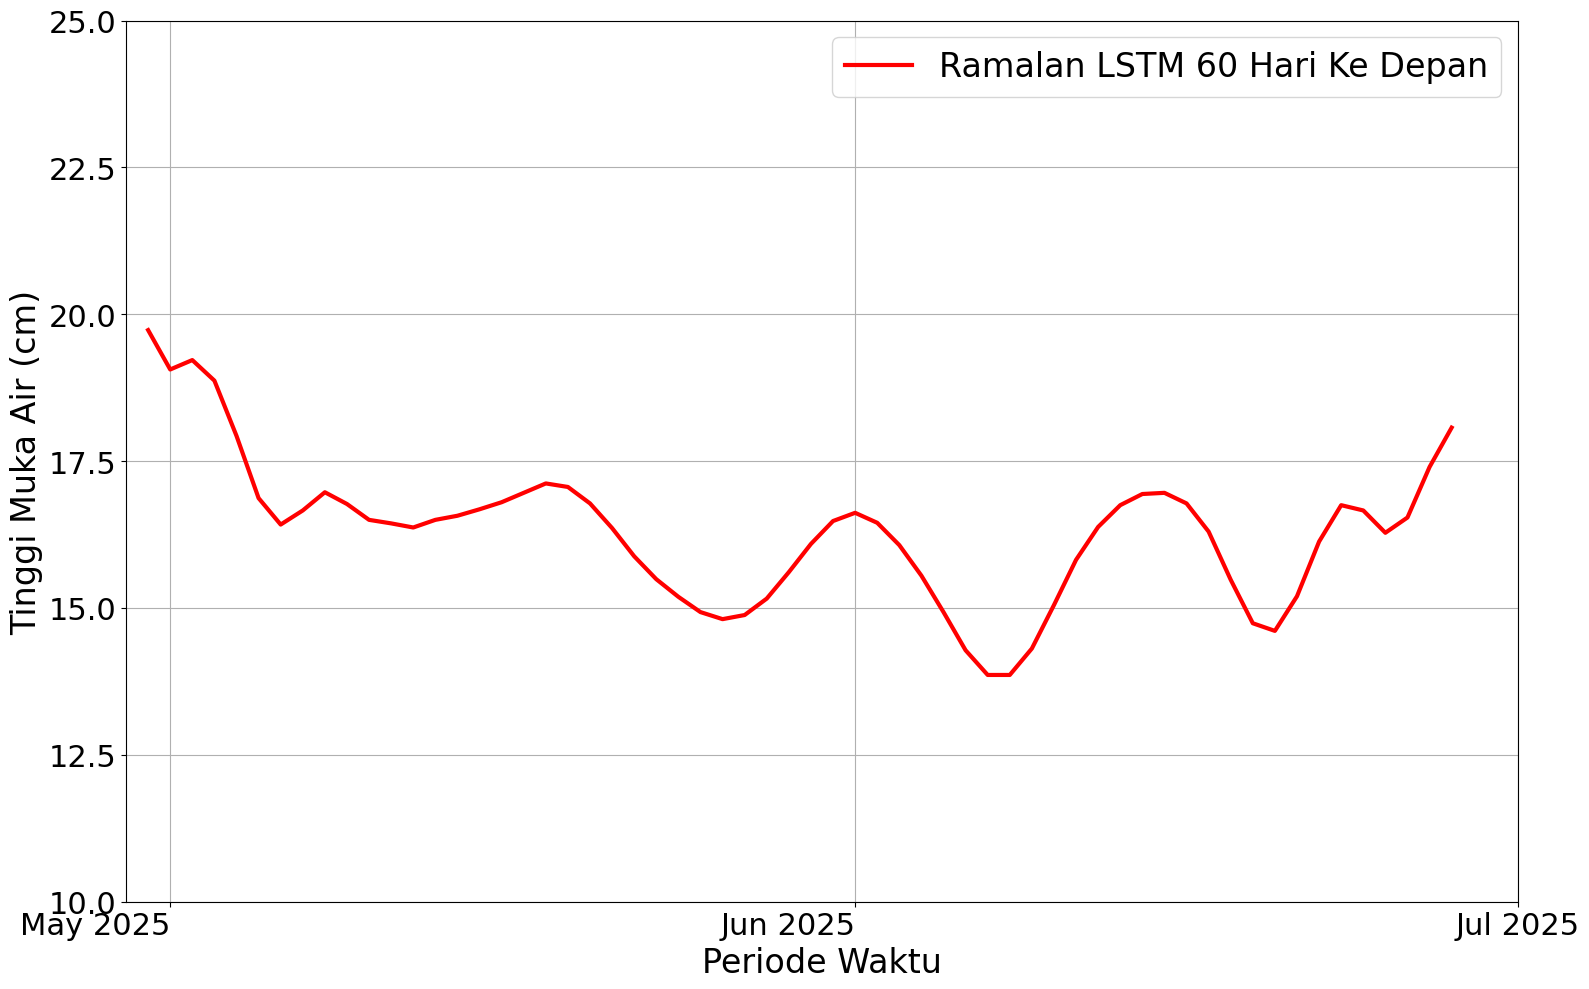

In [15]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Generate future dates starting from the day after the last date in the original data
last_date = data['Daily_Period'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Visualisasi hasil prediksi ke depan (tanpa data aktual)
plt.figure(figsize=(16, 10))
plt.plot(future_dates, future_predictions, lw=3, label='Ramalan LSTM 60 Hari Ke Depan', color='red')

# Label sumbu dan ukuran font
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(np.arange(10, 27.5, 2.5), fontsize=22)
plt.ylim(top=25)

# Format label tanggal pada sumbu X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate(rotation=0)

# Atur batas akhir tampilan waktu prediksi
end_date = pd.to_datetime('2025-07-01')
plt.xlim(last_date, end_date)

# Tambahkan grid dan legend
plt.grid(True)
plt.legend(fontsize=24)
plt.tight_layout()
plt.show()

# Plot Test vs Aktual vs Forecast

In [16]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Revisi%20Analisis/Data%20TMA%20(Jan%202022%20-%20Juni%202025).csv')
data = data.loc[:, ['Daily_Period', 'TMA_Daily']]

data = data.iloc[:1275].reset_index(drop=True)

print(data.head())
print(data.tail())

  Daily_Period  TMA_Daily
0   01/01/2022       10.0
1   02/01/2022       10.0
2   03/01/2022       10.0
3   04/01/2022       10.0
4   05/01/2022       12.5
     Daily_Period  TMA_Daily
1270   24/06/2025  15.000000
1271   25/06/2025  15.416667
1272   26/06/2025  10.000000
1273   27/06/2025  10.000000
1274   28/06/2025  15.833333


Jumlah data uji: 60
Jumlah data aktual forecast: 60
Tanggal awal prediksi: 2025-04-30 00:00:00
Tanggal akhir prediksi: 2025-06-28 00:00:00


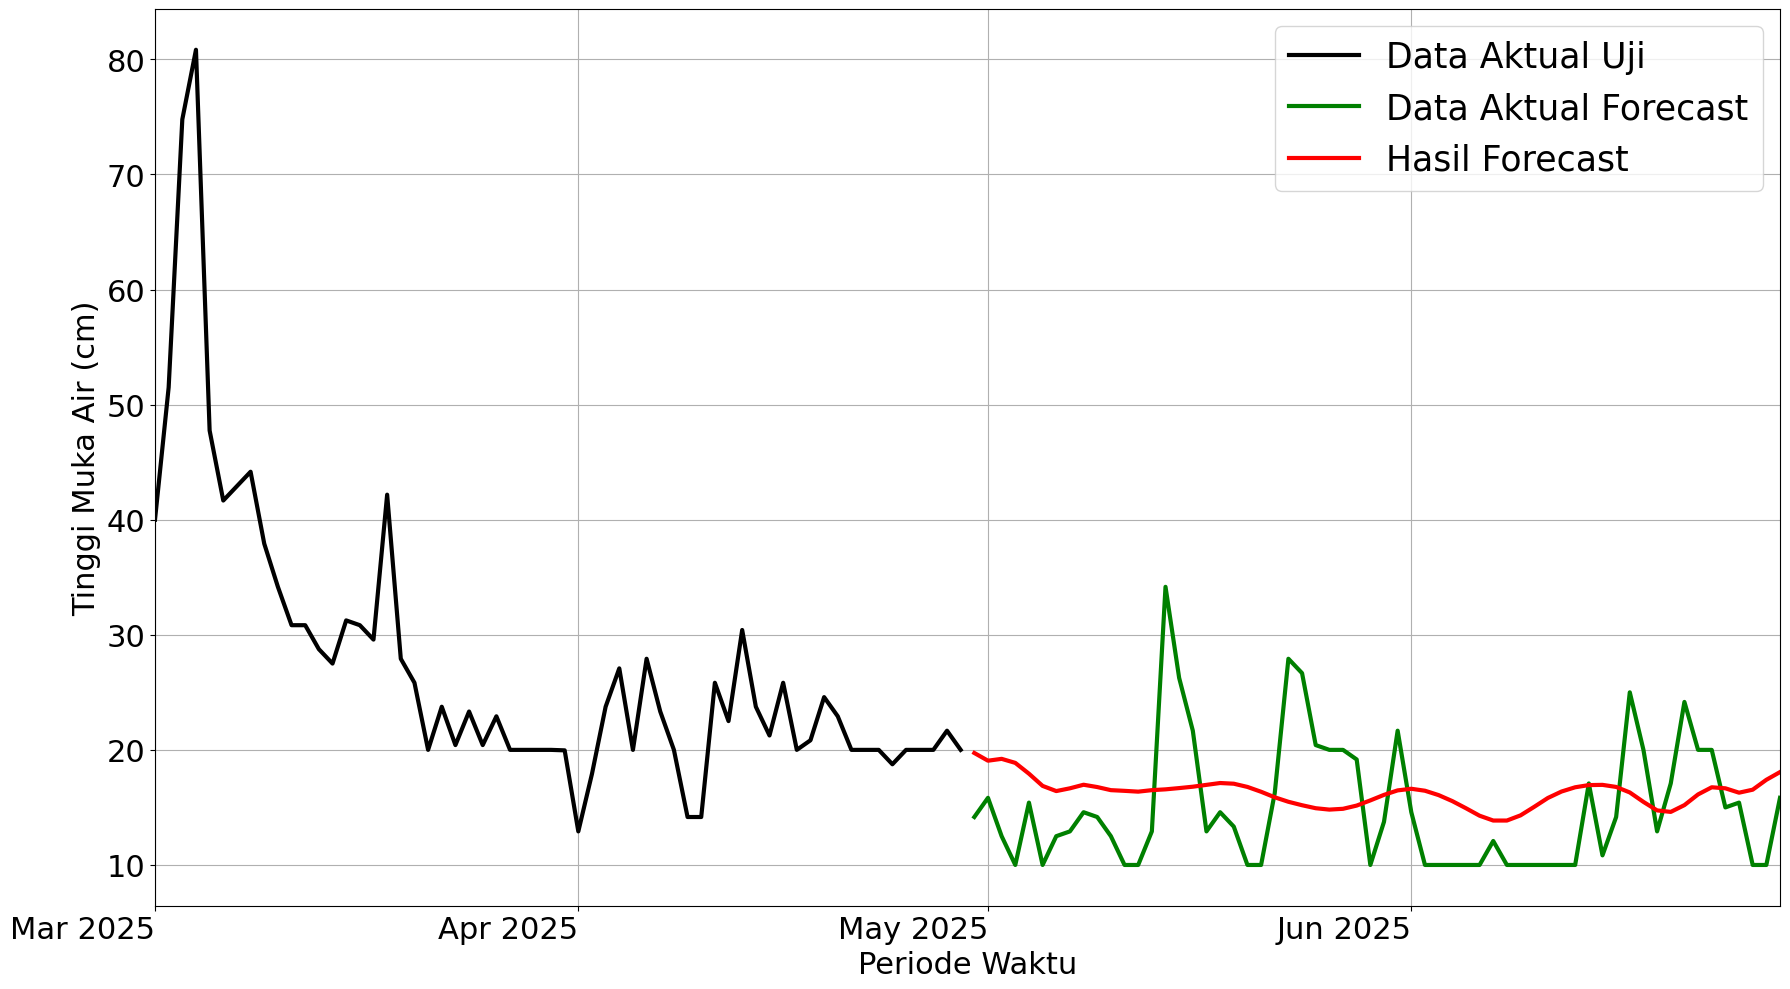

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Revisi%20Analisis/Data%20TMA%20(Jan%202022%20-%20Juni%202025).csv')
data = data.loc[:, ['Daily_Period', 'TMA_Daily']]
data['Daily_Period'] = pd.to_datetime(data['Daily_Period'], dayfirst=True)

data_full = data.iloc[:1275].reset_index(drop=True)

# --- DEFINISI PERIODE ---
test_start = pd.to_datetime('01/03/2025', dayfirst=True)
test_end = pd.to_datetime('29/04/2025', dayfirst=True)

forecast_actual_start = pd.to_datetime('30/04/2025', dayfirst=True)
forecast_actual_end = pd.to_datetime('28/06/2025', dayfirst=True)

# --- FILTER DATA ---
test_data = data_full[(data_full['Daily_Period'] >= test_start) & (data_full['Daily_Period'] <= test_end)]
actual_forecast_data = data_full[(data_full['Daily_Period'] >= forecast_actual_start) & (data_full['Daily_Period'] <= forecast_actual_end)]

# --- CEK DATA ---
print("Jumlah data uji:", len(test_data))
print("Jumlah data aktual forecast:", len(actual_forecast_data))
print("Tanggal awal prediksi:", future_dates[0])
print("Tanggal akhir prediksi:", future_dates[-1])

# --- (Opsional) Inverse transform jika belum ---
try:
    future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()
except:
    pass

# --- PLOT ---
plt.figure(figsize=(18, 10))

# 1. Plot Data Test
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'],
         color='black', linewidth=3, label='Data Aktual Uji')

# 2. Plot Data Aktual Forecast
plt.plot(actual_forecast_data['Daily_Period'], actual_forecast_data['TMA_Daily'],
         color='green', linewidth=3, label='Data Aktual Forecast')

# 3. Plot Forecasting
plt.plot(future_dates, future_predictions,
         color='red', linewidth=3, label='Hasil Forecast')

# Tambahkan garis vertikal putus-putus di awal Mei 2025
#plt.axvline(pd.to_datetime('30/04/2025', dayfirst=True),
#            color='gray', linestyle='--', linewidth=3)

# --- FORMAT PLOT ---
plt.xlabel('Periode Waktu', fontsize=22)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=22)
# plt.title('Perbandingan Data Uji, Aktual Forecast, dan Hasil Forecasting', fontsize=24)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=25)
plt.grid(True)

# Atur format tanggal: tampilkan bulan dan tahun (misal: Mar 2025)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Tampilkan label setiap awal bulan
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Putar label tanggal agar tidak saling tumpang tindih
plt.gcf().autofmt_xdate(rotation=0)

# Atur batas waktu agar sumbu X mencakup Maret–Juli 2025
plt.xlim(test_start, future_dates[-1])
plt.tight_layout()
plt.show()